## E15. 한국어 Chatbot 만들기
Transformer 기술을 이용해서 한국어 chatbot을 만들어 보았습니다. 훈련 데이터는 송영숙님이 공개한 챗봇 데이터를 이용했고 다음카페 "사랑보다 아름다운 실연"에서 자주 나오는 이야기들을 참고하여 제작하였다고 한다. 

### 필요한 모듈 가져오기

In [164]:
import pandas as pd
import numpy as np
import re
import pykospacing
from pykospacing import Spacing
import tensorflow_datasets as tfds
import tensorflow as tf 

### 데이터 가져오기
데이터 셋은 총 11823개이고, 3개의 컬럼으로 이루어져있다. 
1. Q: 질문
2. A: 대답 
3. label: 0, 1, 2 -->  0: 일상다반사, 1: 이별(부정), 2: 사랑(긍정)이다. (출처: https://biology-statistics-programming.tistory.com/61 [히비스서커스의 블로그])

label은 훈련에 필요가 없어서 지워준다. 

In [165]:
data = pd.read_csv('~/aiffel/transformer_chatbot/data/ChatbotData .csv')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [166]:
data['label'].unique()

array([0, 1, 2])

In [167]:
data.drop(columns=['label'], inplace=True)
data.head(3)

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.


In [168]:
print(len(data))

11823


### 데이터 전처리
1. 정규화 
2. 결측치, 중복 제거 
3. Tokenizer 
4. Padding추가 
5. Teacher Forcing (교사강요) 

In [169]:
data.sample(50)

,Q,A
8221,진짜 이제 안녕,맘고생 많았어요.
10904,이거 썸 아냐?,말해보세요. 생각해 볼게요.
8026,정말 너를 받아준게 아니였어.ㅠㅠ,그때의 나를 자책하지 말아요. 무슨 선택을 하든 당신을 믿어요.
5241,회식 했으면 좋겠다.,맛있는거 드세요.
9951,사랑하는 사람과 아침을 함께 맞이하고 싶어,그런 기쁨과 기적도 없을 거예요.
440,꽃다발 준비했어,멋진 선물이네요.
11295,주변에서 다 별로라고 한 짝남 그냥 맘을 접어야할까?,다른 사람들이 별로라고 말하는 이유를 생각해보세요.
2672,스타트업에 취직해도 될까?,모 아니면 도예요.
2674,스타트업에 투자해볼까?,그쪽 방면에 대한 지식이 있었으면 좋겠네요.
437,꽃다발 선물 괜찮지?,센스있는 선물이에요.


In [170]:
spacing = Spacing()

#### Regular Expression (정규화) 
샘플로 데이터를 살펴봤을때를 전반적으로 비속어, 외국어, URL주소 등이 섞여 있지도 않다. 다음과 같은 정규화 작업을 해주었다.
1. spacing: 띄어쓰기가 되어 있지 않은 문장이 간혹 있어서 띄어쓰기를 해주었다. 
2. spacing before punctuaion 
3. 한글, 숫자, 영문, ',.?!' 이외의 특수문자를 제거해주었다. 
4. '...' 등이 있어서 '.' 바꾸어 주었다. 

In [171]:
def preprocess_sentence(sentence):
    sentence = spacing(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub('[^a-zA-Z0-9가-힣?.,!]', ' ', sentence) 
    sentence = re.sub('[.]+','.', sentence)
    sentence = sentence.strip()
    return sentence 

In [172]:
# 샘플 테스트 
preprocess_sentence(data.loc[8457, 'Q'])

'한순간에 변한 사람 . 그리고 예의에 대해 .'

#### 중복, 결측치 제거 

In [173]:
data.drop_duplicates(subset=['Q'], inplace=True) 
data = data.dropna(how = 'any') 
print(len(data))

11662


#### tokenizer 
1. tensorflow에 있는 SubwordTextEncoder를 이용해서 단어장을 만들어주었다. 
2. Start, End 토큰을 단어장에 추가해주었다. 

In [174]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data['Q'] + data['A'], target_vocab_size=2**15) # vocab_size = 32768 

In [175]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [176]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [24952]
END_TOKEN의 번호 : [24953]


In [177]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

24954


In [178]:
tokenizer.encode(data.loc[8457, 'Q'])

[9676, 6920, 925, 24742, 452, 14183, 21096, 24742]

#### padding
1. padding을 해 주기 위해 데이터의 문장길이 평균, 최대, 표준편차를 구한다. 
2. padding의 최대길이는 평균+표준편차\*2.5 정도로 해주기로 한다 --> 97.7% coverage. 
3. max_lenth = 30 

In [179]:
# 텍스트데이터 문장길이의 리스트를 생성
total_data_text = list(data['Q']) + list(data['A'])
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  13.971145601097582
문장길이 최대 :  76
문장길이 표준편차 :  6.529767665096625


In [180]:
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)*100))

pad_sequences maxlen :  30
전체 문장의 97.75338706911336%가 maxlen 설정값 이내에 포함됩니다. 


In [181]:
MAX_LENGTH = 30

In [182]:
def tokenize_and_filter(inputs, outputs):
    
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 30 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
  # 최대 길이 30으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [183]:
inputs = list(data['Q'])
outputs = list(data['A'])

In [184]:
questions, answers = tokenize_and_filter(inputs, outputs)

In [185]:
print(len(questions))

11660


#### Teacher Forcing (교사강요) 
* tf.data.Dataset API는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API. 이를 적극 사용하기 위해서 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 해야한다.     
* 이전 자신의 출력이 현재 자신의 상태를 결정하는 모델을 자기회귀 모델(auto-regressive model, AR)이다. RNN 언어 모델은 대표적인 자기 회귀 모델의 예이며, 트랜스포머의 디코더 또한 자기회귀 모델이다.     
* **교사강요:** 테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법이다. 예를들어, what will the fat cat sit on라는 훈련 샘플이 있다면, what will the fat cat sit 시퀀스를 모델의 입력으로 넣으면, will the fat cat sit on를 예측하도록 훈련된다. will, the, fat, cat, sit, on는 각 시점의 레이블이된다. 훈련할 때 교사 강요를 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블. 즉, 실제 알고있는 정답을 t+1 시점의 입력으로 사용한다. 물론, 훈련 과정에서도 이전 시점의 출력을 다음 시점의 입력으로 사용하면서 훈련 시킬 수도 있지만 이는 한 번 잘못 예측하면 뒤에서의 예측까지 영향을 미쳐 훈련 시간이 느려지게 되므로 교사 강요를 사용하여 RNN을 좀 더 빠르고 효과적으로 훈련시킬 수 있다. 
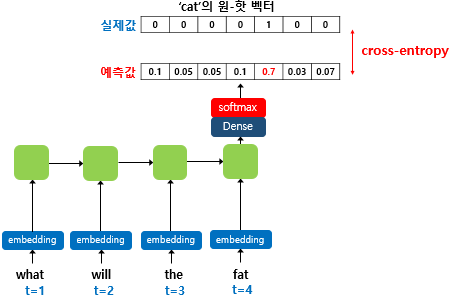 (출처: https://wikidocs.net/46496)    
* 트랜스포머 디코더에서도 교사 강요(Teacher Forcing) 를 적용한다.     
* answers\[:, :-1\]를 디코더의 입력값, answers\[:, 1:\]를 디코더의 레이블로 사용합니다.     

In [186]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Transformer 
트랜스 포머에는 다음과 같은 메커니즘이 들어간다. 
* Positional Encoding
* Masking(마스킹) 
* Multihead Attention

위의 메커니즘을 통해서 encoder 와 decoder를 만들어보았다.  

#### Positional Encoding 
트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받는다. 트랜스포머가 RNN과 결정적으로 다른 점이 바로 이점이다. RNN에는 어차피 문장을 구성하는 단어들이 어순대로 모델에 입력되므로, 모델에게 따로 어순 정보를 알려줄 필요가 없었습니다. 그러나, 트랜스포머는 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려 주기 위해, 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터(Positional Encoding) 값을 더해서 모델의 입력으로 삼는다.     

포지셔널 인코딩의 벡터값은 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해줌으로써 단어의 순서 정보를 더하여 준다. 임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 문장 벡터 행렬과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어진다. d-model은 임베딩 벡터의 차원을 의미하고 있고, pospos는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, ii는 임베딩 벡터 내의 차원의 인덱스를 의미한다. 이렇게 임베딩 행렬과 포지셔널 행렬이라는 두 행렬을 더함으로써 각 단어 벡터에 위치 정보를 더해주게 된다.    
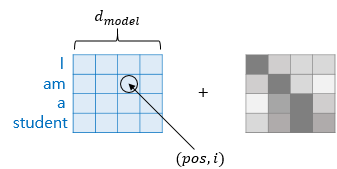

In [187]:
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
    # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 마스킹     
마스킹(Masking) 이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법이다. 트랜스포머에서는 어텐션을 위해서 padding mask와 look ahead mask를 사용한다.    


1. **Padding masking**     
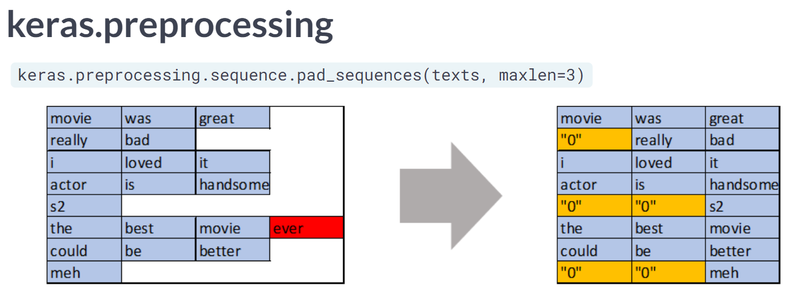
위의 사진은 케라스의 pad_sequences()를 사용하여 패딩을 하는 과정을 시각화한 것이다. 이렇게 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외해야 한다. 때문에, 이를위해, 패딩 마스킹은 숫자 0의 위치를 체크한다.      


2. **Look ahead masking(다음 단어 가리기)**     
RNN과 트랜스포머는 문장을 입력받을 때 입력받는 방법이 전혀 다르다. RNN은 step이라는 개념이 존재해서 각 step마다 단어가 순서대로 입력으로 들어가는 구조인 반면 트랜스포머의 경우에는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있다. 그리고 이 특징 때문에 추가적인 마스킹(Masking) 을 필요합니다.    
전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있다. 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것이기 때문에 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법이다. 이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹 한다. 예를 들어 Query 단어가 '찾고'라고 한다면, 이 '찾고'라는 행에는 \<s>, <나는>, <행복을>, <찾고>까지의 열만 보이고 그 뒤 열은 아예 빨간색으로 칠해져 있다. 즉, 유사도를 구할 수 없도록 해놓았습니다. 저 빨간색 부분을 마스킹 함수로 구현 한다.            
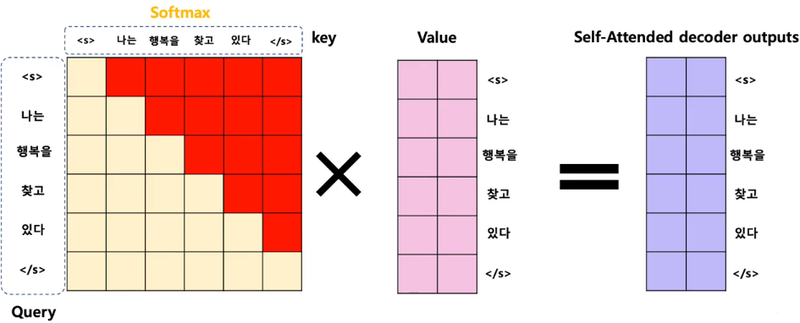

In [188]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [189]:
# create padding mask 
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

#### Multihead Attention 
트랜스포머는 총 세 가지의 어텐션을 사용한다 - encoder self-attention, decoder self-attention, encoer/decoder attention       
* 인코더 셀프 어텐션 : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
* 디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
* 인코더-디코더 어텐션 : 디코더가 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.
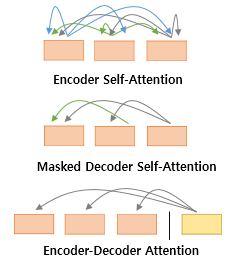

트랜스포머의 어텐션 함수에 사용되는 쿼리(Query), 키(Key), 밸류(Value) 는 기본적으로 '단어 (정보를 함축한) 벡터'이다. '단어 벡터'란 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 거친 후의 단어 벡터이다. 

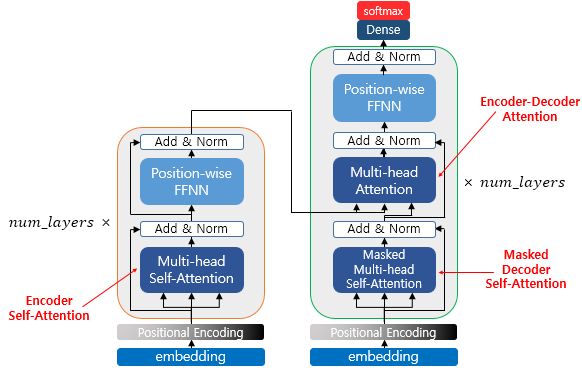

* 셀프 어텐션:유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이다. 즉, 인코더-디코더 어텐션은 서로 다른 단어 목록(인코더 내 단어와 디코더 내 단어) 사이에서 유사도를 구하기에 셀프 어텐션이 아니다. 

In [190]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

####  encoder layer
하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어진다. 바로 셀프 어텐션과 피드 포워드 신경망이다. 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어집니다. 
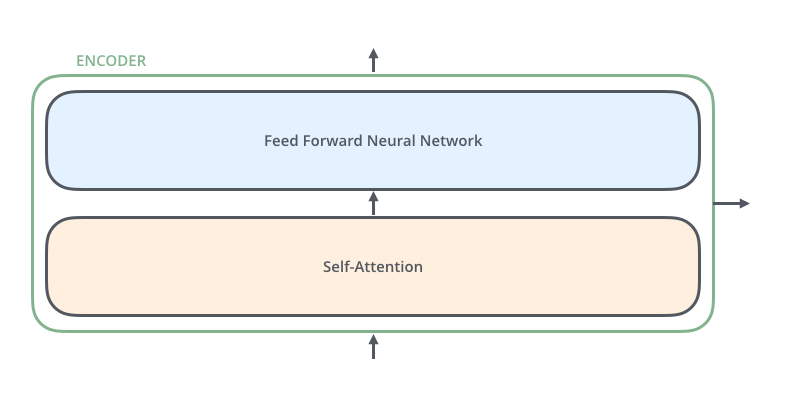

In [191]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

  # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


In [192]:
# 인코더 하나의 레이어를 함수로 구현.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


#### encoder 
인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다. 인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용되었다. 위 그림에서는 Normalize라고 표시된 부분에 해당된다. 트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓습니다. 
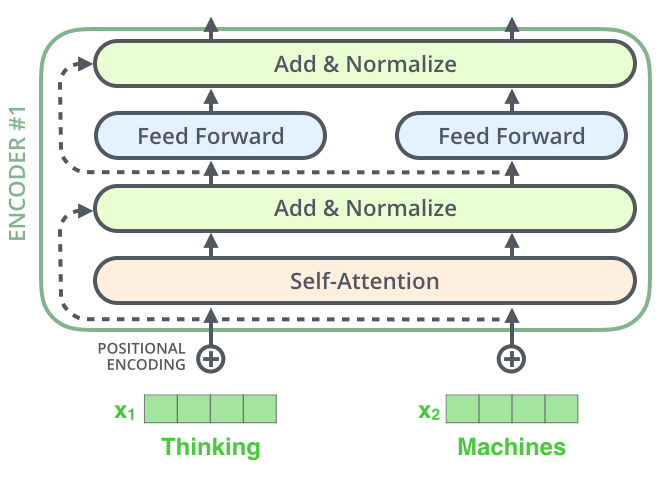

In [193]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),)([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### decoder layer
첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망이다. 인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정이다. 인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행한다. 디코더의 세 개의 서브 층을 내부적으로 구현한 디코더의 함수는 다음과 같다.   
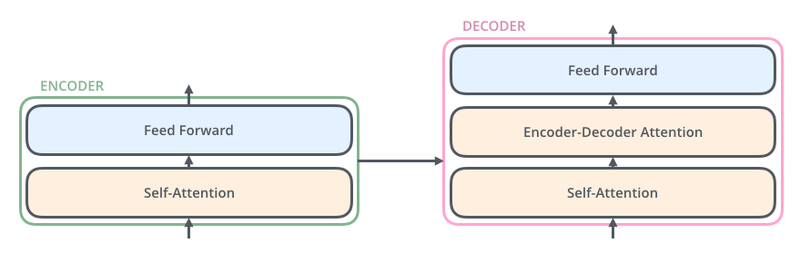
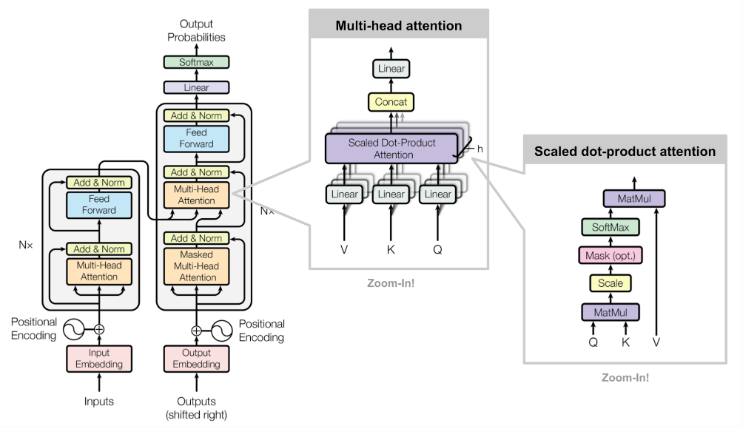

In [194]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

#### decoder 
이렇게 구현한 디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성된다 인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓는다. 

In [195]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,name=name)


#### Transformer Model 구조 
1. Masking(마스킹)
   * encoder padding 
   * look ahead mask 
   * decoder padding mask  
2. encoder
3. decoder 
4. 연결층 

In [196]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
    create_padding_mask, output_shape=(1, 1, None),
    name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, 
        output_shape=(1, None, None), 
        name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

  # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,)(inputs=[inputs, enc_padding_mask])

  # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

#### 모델 만들기 
논문에서 num_layers는 6, d-Model은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용했다.
* 하이퍼파라미터 
    * num_layers:인코더와 디코더의 층의 개수
    * d_model: 인코더와 디코더 내부의 입, 출력의 고정 차원
    * num_heads: 멀티 헤드 어텐션에서의 헤드 수 
    * units: 피드 포워드 신경망의 은닉층의 크기
    * dropout = Fraction of the input units to drop    
         
        
* d_model, num_heads 는 아래의 설명을 참고하자.      
트랜스포머에서 num_heads 변수는 기계가 몇 개의 머리를 사용할지, 다시 말해 병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 하이퍼파라미터이다. 포지셔널 인코딩에서 d_model은 임베딩 벡터의 차원이다. 아래의 그림과 같이 트랜스포머의 초기 입력인 문장 행렬의 크기는 문장의 길이를 행으로, d_model을 열의 크기를 가진다. 트랜스포머는 입력된 문장 행렬을 num_heads의 수만큼 쪼개서 어텐션을 수행하고, 이렇게 얻은 num_heads의 개수만큼의 어텐션 값 행렬을 다시 하나로 concatenate합니다. num_heads가 8개인 경우인데, 다시 concatenate하면서 열의 크기가 d_model이 된다. 

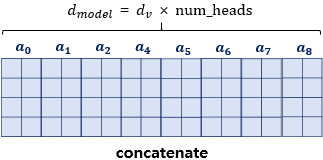

In [197]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 
D_MODEL = 256 
NUM_HEADS = 8  
UNITS = 512 
DROPOUT = 0.1 

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    7442432     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 2. loss function(손실함수)
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야한다. 

In [198]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)


#### 3. Learning rate
딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터이다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 하는데, 여기서는 논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용했다. 

In [199]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#### 4. Model compile, training 

In [200]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [202]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
183/183 [==============================] - 134s 731ms/step - loss: 1.8406 - accuracy: 0.0611
Epoch 2/30
183/183 [==============================] - 134s 730ms/step - loss: 1.4093 - accuracy: 0.0673
Epoch 3/30
183/183 [==============================] - 134s 730ms/step - loss: 1.2168 - accuracy: 0.0722
Epoch 4/30
183/183 [==============================] - 133s 728ms/step - loss: 1.1001 - accuracy: 0.0785
Epoch 5/30
183/183 [==============================] - 134s 732ms/step - loss: 1.0164 - accuracy: 0.0843
Epoch 6/30
183/183 [==============================] - 133s 729ms/step - loss: 0.9367 - accuracy: 0.0901
Epoch 7/30
183/183 [==============================] - 133s 730ms/step - loss: 0.8529 - accuracy: 0.0977
Epoch 8/30
183/183 [==============================] - 133s 729ms/step - loss: 0.7665 - accuracy: 0.1069
Epoch 9/30
183/183 [==============================] - 133s 729ms/step - loss: 0.6774 - accuracy: 0.1178
Epoch 10/30
183/183 [==============================] - 133s 729m

### 테스트
예측(inference) 단계는 기본적으로 다음과 같은 과정을 거친다. 

* 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다. 
* 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
* 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
* 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
* 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
* END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.
* 위의 과정을 모두 담은 decoder_inference() 함수를 만든다. 

In [209]:
def decoder_inference(sentence):
    
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만든다. 

In [210]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

#### 최종 테스트

In [227]:
sentence_generation('나 어떻게 하지?')

입력 : 나 어떻게 하지?
출력 : 어떻게 하느냐에 따라 다를 거예요.


'어떻게 하느냐에 따라 다를 거예요.'

In [228]:
sentence_generation('피곤하다')

입력 : 피곤하다
출력 : 당화의 시작이죠.


'당화의 시작이죠.'

In [225]:
sentence_generation('오늘은 금요일이다')

입력 : 오늘은 금요일이다
출력 : 그럴 수 있어요.


'그럴 수 있어요.'

In [214]:
sentence_generation('남자친구는 어떤 사람이야?')

입력 : 남자친구는 어떤 사람이야?
출력 : 어떻게 하느냐에 따라 다를 거예요.


'어떻게 하느냐에 따라 다를 거예요.'

In [221]:
sentence_generation('커피 마시고 싶다. 같이 마실래?')

입력 : 커피 마시고 싶다. 같이 마실래?
출력 : 용기를 내보세요.


'용기를 내보세요.'